In [1]:
# Import Modules
import sys,os
path = os.getcwd() 
parent = os.path.dirname(path) 
parent = os.path.dirname(parent) 
sys.path.append(parent)

from model_clarifier.model_clarify import *

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import pickle
import joblib

In [2]:
# Define target feature
TARGET_COLUMN = 'cat_rt'

# read in the model and data for this tutorial
model = joblib.load('RandomForest.pkl')
data  = pd.read_csv('example_data.csv')

# get actual target data
targets = data[TARGET_COLUMN].values

# only want to use these columns below
cols_to_use = ['dllwave_flux', 'dwpt2m', 'fric_vel', 'gflux', 'high_cloud',
            'lat_hf', 'low_cloud', 'mid_cloud', 'sat_irbt', 'sens_hf',
            'sfcT_hrs_ab_frez', 'sfcT_hrs_bl_frez', 'sfc_rough', 'sfc_temp',
            'swave_flux','temp2m', 'tmp2m_hrs_ab_frez', 'tmp2m_hrs_bl_frez',
            'tot_cloud', 'uplwav_flux','vbd_flux', 'vdd_flux','wind10m',
            'date_marker', 'urban','rural','d_ground','d_rad_d','d_rad_u',
            'hrrr_dT']

# get predictor subset of dataframe (only the predictors used in training the model)
data = data[cols_to_use]

# testing purposes
# numpy_data     = data.values
# feature_names  = data.columns

# always the default here
classification = True

/Users/Home/.conda/envs/deep/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/Home/.conda/envs/deep/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
clf  = LogisticRegression(C=1)
clf.fit(data, targets)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

# Initializing ModelClarify

To initialize `ModelClarify`, you need a model object (e.g., a trained sci-kit learn model object) or a list of model objects and a `pandas.Dataframe` of the training examples and targets. 
If it is the case that `examples` and `targets` are arrays, then you must provide the feature names so that the data can be converted to a `pandas.DataFrame`. Now we can explore the various functions and plotting availabe in `ModelClarify`. 

In [4]:
myInterpreter = ModelClarify(model=[model,clf], 
                             examples=data, 
                             targets=targets, 
                             classification=True)

# Permutation Importance

The permutation importance calculations are performed by a stripped-down version of PermutationImportance (see https://permutationimportance.readthedocs.io/en/latest/ for additional details). In this example, we want the top 5 predictors as determined by the multipass permutation importance method (SOURCE). Additionally, we are using the Area under the Curve (AUC) as our error metric. 

In [5]:
#returns a dictionary of top 5 predictors
results = myInterpreter.permutation_importance(n_multipass_vars=5, evaluation_fn='auc', nbootstrap=1, njobs=2)
important_vars = list(results['RandomForestClassifier'].retrieve_multipass().keys())
print(results['RandomForestClassifier'].retrieve_multipass())

Processing RandomForestClassifier...
Using 2 of processors to compute importance...
Starting on the important variable 0 out of 5...
Starting on the important variable 1 out of 5...
Starting on the important variable 2 out of 5...
Starting on the important variable 3 out of 5...
Starting on the important variable 4 out of 5...
Processing LogisticRegression...
Using 2 of processors to compute importance...
Starting on the important variable 0 out of 5...
Starting on the important variable 1 out of 5...
Starting on the important variable 2 out of 5...
Starting on the important variable 3 out of 5...
Starting on the important variable 4 out of 5...
{'dllwave_flux': (0, array([1.])), 'dwpt2m': (1, array([1.])), 'fric_vel': (2, array([1.])), 'gflux': (3, array([1.])), 'high_cloud': (4, array([1.]))}


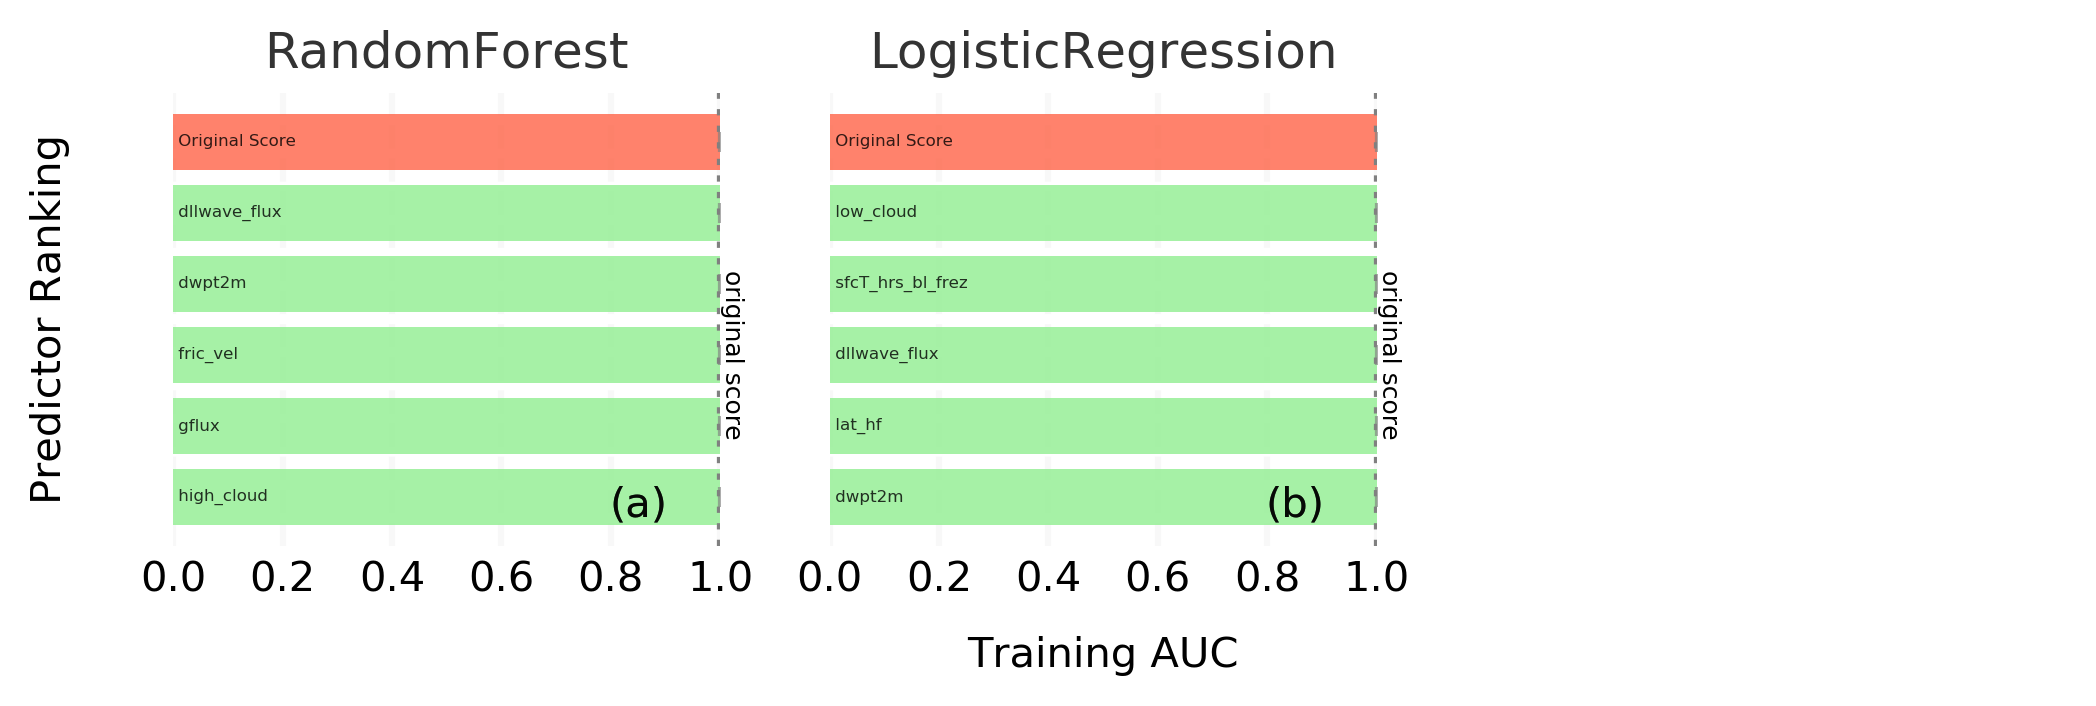

In [6]:
myInterpreter.plot_importance(multipass=True, 
                              metric = "Training AUC",
                              num_vars_to_plot=10)

# Accumulated Local Effect

Using 2 processors...

 Start Time: 13:01:01.677331
('RandomForestClassifier', 'dllwave_flux') RandomForestClassifier__dllwave_flux
('RandomForestClassifier', 'dwpt2m') RandomForestClassifier__dwpt2m
('RandomForestClassifier', 'fric_vel') RandomForestClassifier__fric_vel
('RandomForestClassifier', 'gflux') RandomForestClassifier__gflux
('RandomForestClassifier', 'high_cloud') RandomForestClassifier__high_cloud
('LogisticRegression', 'dllwave_flux') LogisticRegression__dllwave_flux
('LogisticRegression', 'dwpt2m') LogisticRegression__dwpt2m
('LogisticRegression', 'fric_vel') LogisticRegression__fric_vel
('LogisticRegression', 'gflux') LogisticRegression__gflux
('LogisticRegression', 'high_cloud') LogisticRegression__high_cloud
End Time:  13:01:05.038191
dict_keys(['dwpt2m', 'fric_vel', 'high_cloud', 'dllwave_flux', 'gflux'])
KWARGS: {'color': 'orangered'}
KWARGS: {'color': 'orangered'}
KWARGS: {'color': 'orangered'}
KWARGS: {'color': 'orangered'}
KWARGS: {'color': 'orangered'}


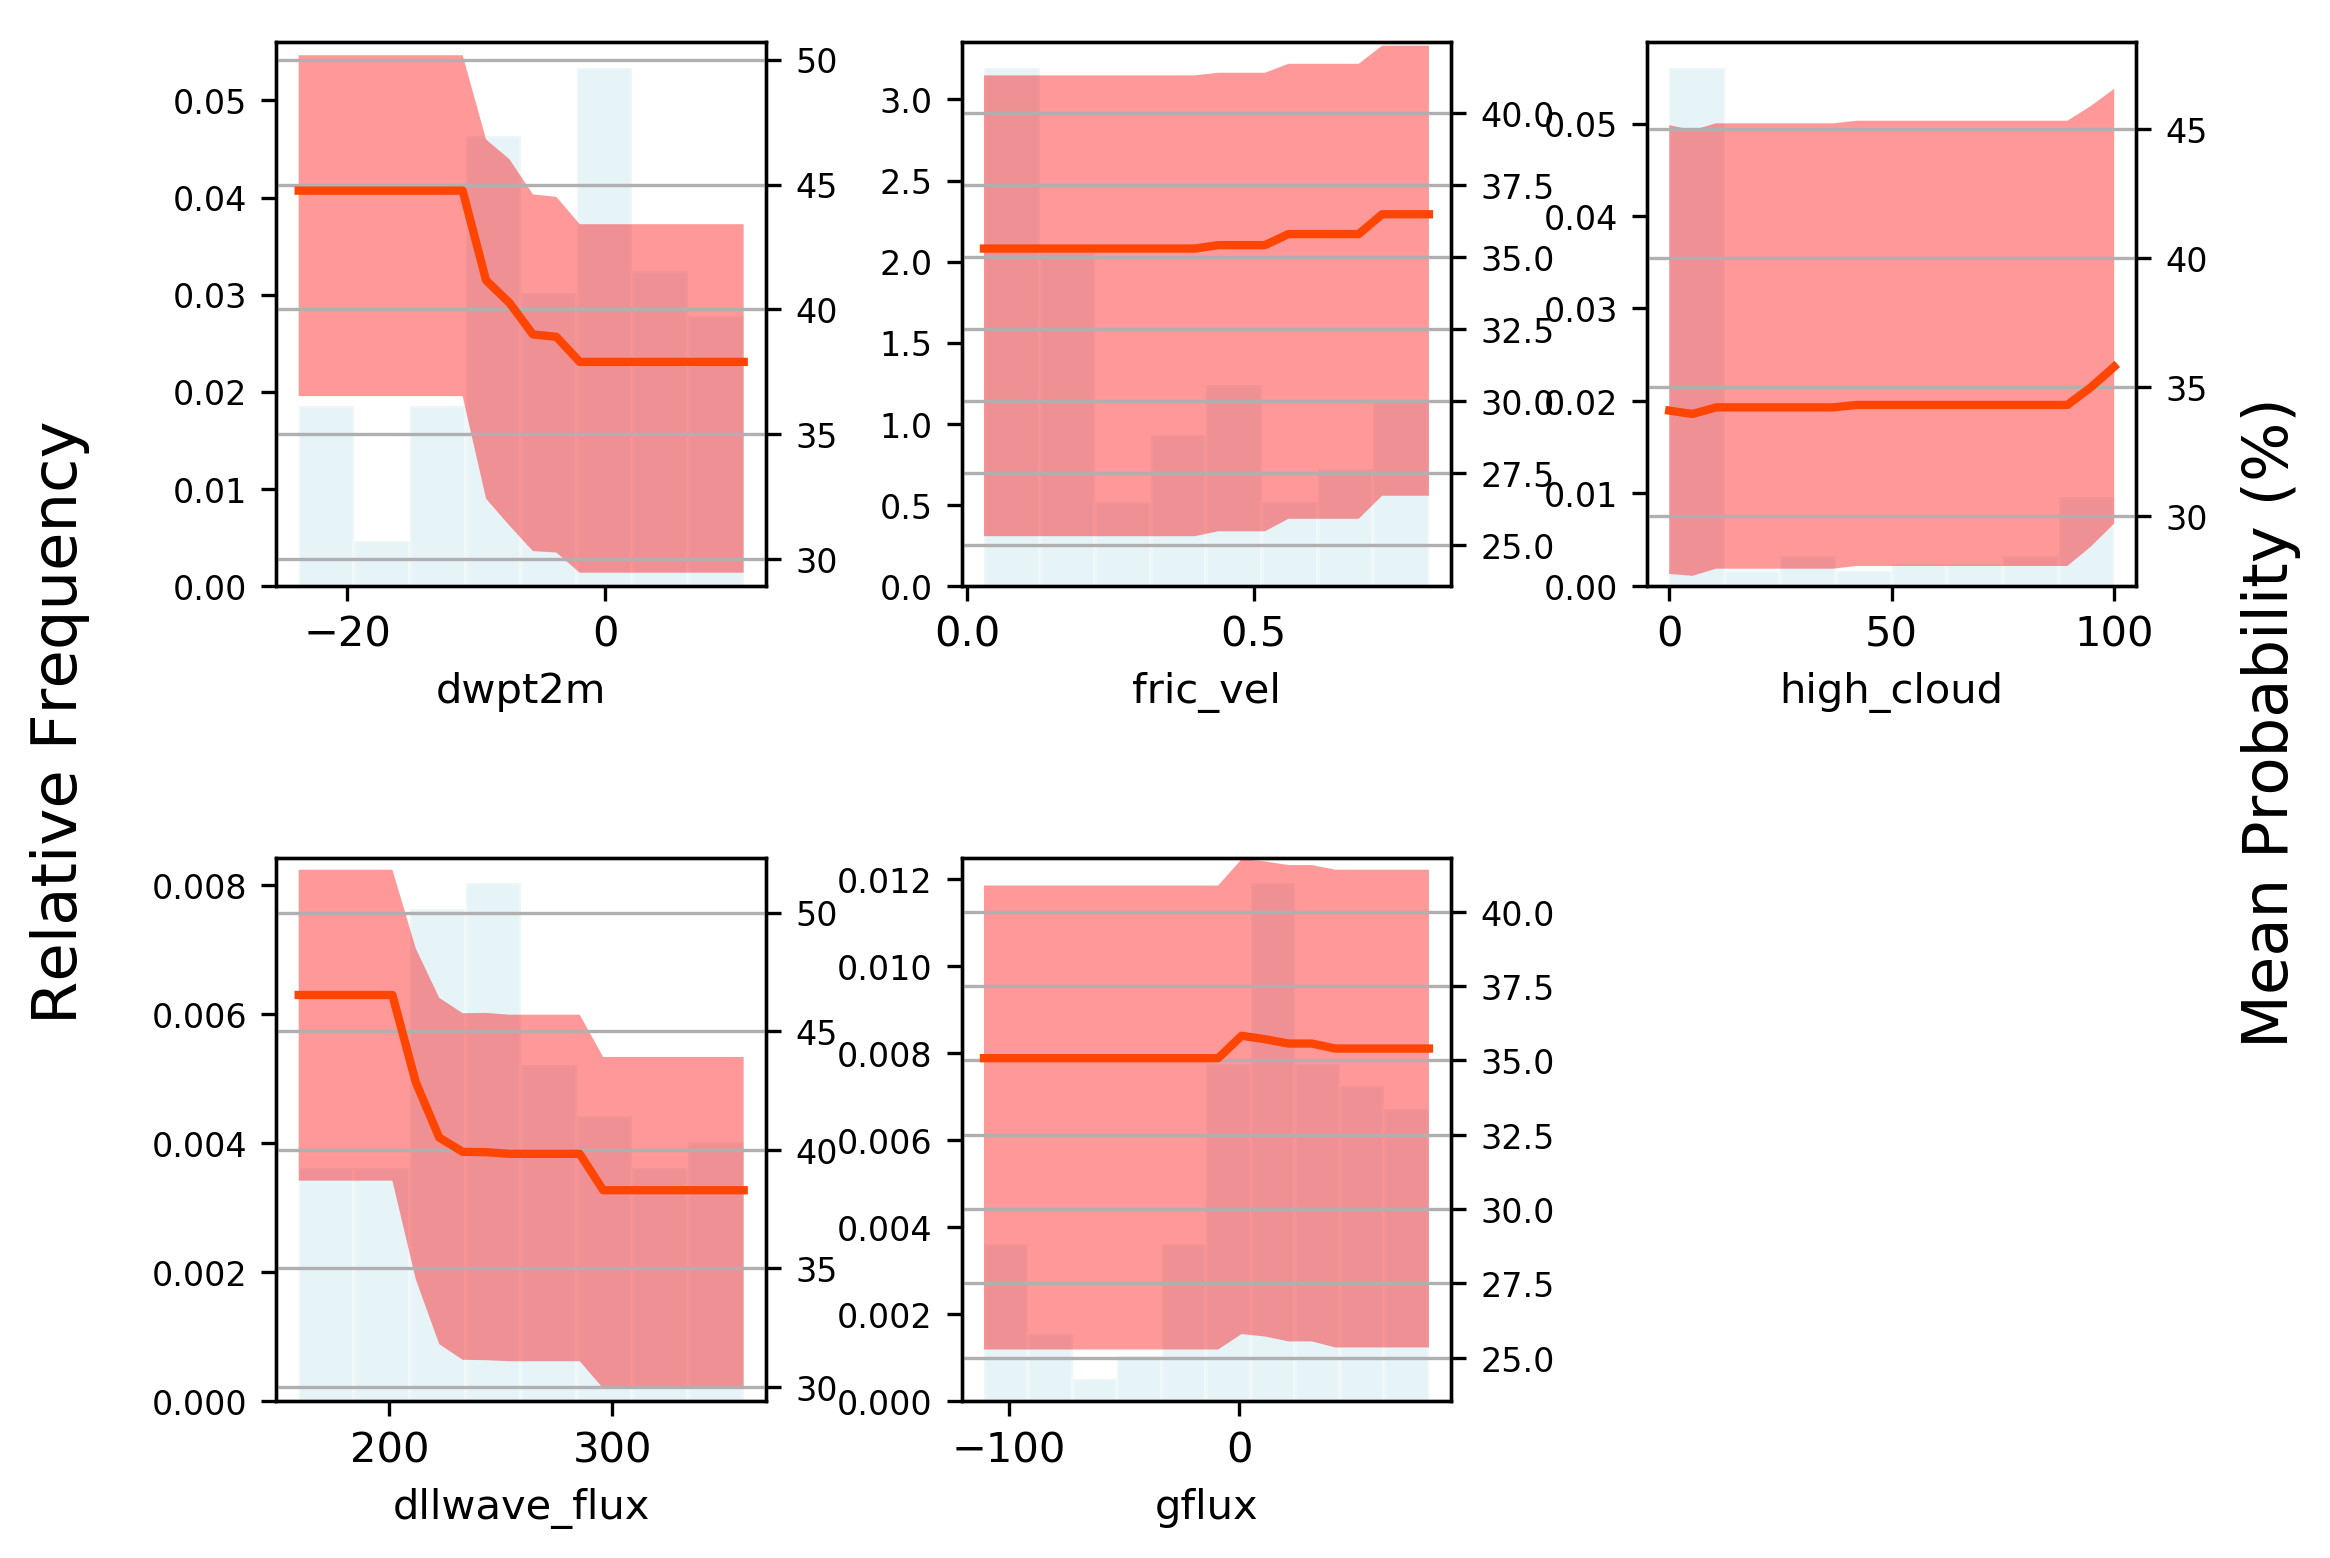

In [7]:
results = myInterpreter.run_pd(features=important_vars, nbootstrap=10, subsample=1.0, njobs=2)

print(results.keys())

fig, axes = myInterpreter.plot_pd()